In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.nn import Module, Sequential
from torch.nn import Linear, ReLU, LeakyReLU
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
class FeatureExtractor(nn.Module):
    def __init__(self, num_features, output_neurons):
        super(FeatureExtractor, self).__init__()
        self.fc_input = nn.Sequential(
            nn.Linear(num_features, 50),
            nn.LeakyReLU()
        )
        self.fc_l1 = nn.Sequential(
            nn.Linear(50, 30),
            nn.LeakyReLU()
        )
        self.fc_l2 = nn.Sequential(
            nn.Linear(30, 20),
            nn.LeakyReLU()
        )
        self.fc_output = nn.Sequential(
            nn.Linear(20, output_neurons),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc_input(x)
        x = self.fc_l1(x)
        x = self.fc_l2(x)
        output = self.fc_output(x)
        return output

class RegressionModel(nn.Module):
    def __init__(self, num_features, output_neurons):
        super(RegressionModel, self).__init__()
        self.feature_extractor = FeatureExtractor(num_features, output_neurons)
        self.linear_regression = nn.Linear(output_neurons + 3, 1)  # Concatenate with 3 features: Open, High, Low
        
    def forward(self, x):
        features = self.feature_extractor(x)
        concatenated = torch.cat((features, x[:, :3]), dim=1)  # Concatenate with 'Open', 'High', 'Low' features
        output = self.linear_regression(concatenated)
        return output

In [3]:
# Load and preprocess data
file_path_train = "../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Train.csv"
file_path_test = "../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Test.csv"
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%m/%d/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%m/%d/%Y')
df_train['Volume'] = df_train['Volume'].str.replace(',', '').astype(int)
df_test['Volume'] = df_test['Volume'].str.replace(',', '').astype(int)
X_train = df_train[['Open', 'High', 'Low', 'Volume']].values
X_test = df_test[['Open', 'High', 'Low', 'Volume']].values
y_train = df_train['Close'].values.reshape(-1, 1)
y_test = df_test['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)
X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = scaler.fit_transform(y_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoader for both training and validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [4]:
# Create an instance of the regression model
num_features = X_train_tensor.shape[1]
output_neurons = 6  # Number of neurons in the last hidden layer of the feature extractor
model = RegressionModel(num_features, output_neurons)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.00005)
loss_fn = torch.nn.MSELoss()

# Training the model
def train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=300):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            epoch_val_loss = 0.0
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                epoch_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss /= len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/300, Train Loss: 1.0759508507863191, Validation Loss: 0.9371469493896242
Epoch 2/300, Train Loss: 1.0738657639467455, Validation Loss: 0.9357202488278585
Epoch 3/300, Train Loss: 1.0716958737989544, Validation Loss: 0.9342907004886203
Epoch 4/300, Train Loss: 1.0697067166654537, Validation Loss: 0.9329582471696157
Epoch 5/300, Train Loss: 1.067570642021968, Validation Loss: 0.9315139017407856
Epoch 6/300, Train Loss: 1.0655441805572206, Validation Loss: 0.9300814091213165
Epoch 7/300, Train Loss: 1.0633696913719177, Validation Loss: 0.9286056681284829
Epoch 8/300, Train Loss: 1.0612122308662824, Validation Loss: 0.9270851139038329
Epoch 9/300, Train Loss: 1.0590961759180482, Validation Loss: 0.9255330203071473
Epoch 10/300, Train Loss: 1.056900921209195, Validation Loss: 0.9239754090233455
Epoch 11/300, Train Loss: 1.054686205287577, Validation Loss: 0.9224276977872091
Epoch 12/300, Train Loss: 1.052558465577499, Validation Loss: 0.920893703188215
Epoch 13/300, Train Loss: 1.05

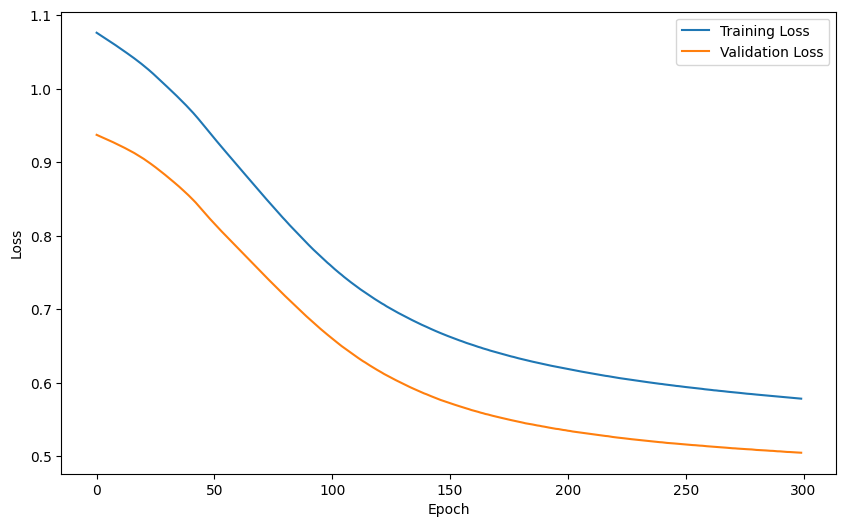

In [5]:
train_model(model, optimizer, loss_fn, train_loader, val_loader)

MAE: 0.8043138384819031, MSE: 0.8432472944259644


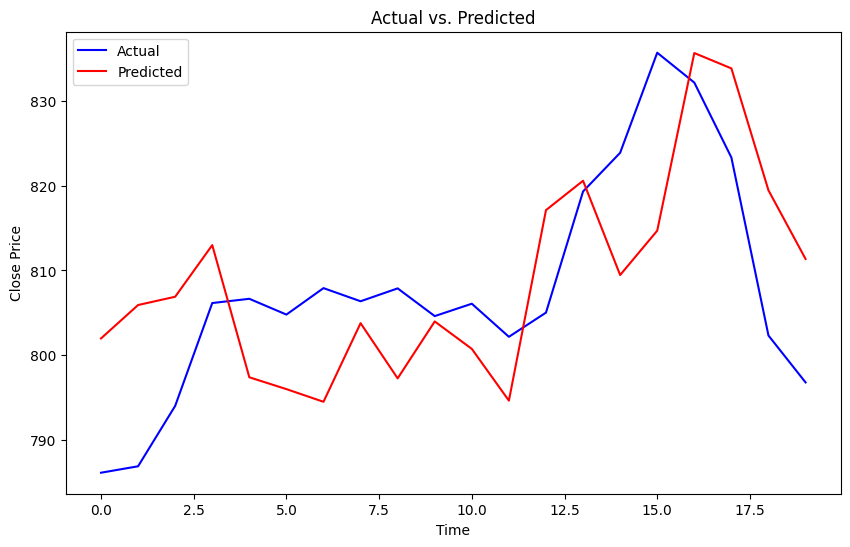

In [6]:
# Evaluate the model on the test set and print performance metrics
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mae = mean_absolute_error(y_test.detach().numpy(), predictions.detach().numpy())
        mse = mean_squared_error(y_test.detach().numpy(), predictions.detach().numpy())
        print(f"MAE: {mae}, MSE: {mse}")
        return predictions

predictions = evaluate_model(model, X_test_tensor, y_test_tensor)

# Denormalize predictions
predictions_denormalized = scaler.inverse_transform(predictions.detach().numpy())
y_test_denormalized = scaler.inverse_transform(y_test_tensor.numpy())

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_denormalized, color='blue', label='Actual')
plt.plot(predictions_denormalized, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()